<a href="https://colab.research.google.com/github/paveltyukin/gb_python_libs/blob/project/google_colab_ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовой проект для курса "Python для Data Science"

**Задание:** Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). 
С помощью полученной модели предсказать цены для квартир из файла test.csv.

**Целевая переменная:** Price

**Основная метрика:** R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### описание датасета:
* Id - номер квартиры в сете, можно объединять по нему данные разных таблиц
* DistrictId - категориальный признак. принадлежность разным районам
* Rooms - количество комнат. есть 0/NaN комнаты - это ошибка данных или студия/нежилое помещение
* Square, LifeSquare, KitchenSquare - общая, жилая и площадь кухни
* Floor - этаж квартиры
* HouseFloor - сколько этажей в доме
* HouseYear - когда построен дом
* Ecology_1 - состояние экологии. будет задача попробовать использовать поле. сделать выводы о нём.
* Ecology_2, Ecology_3 - какие-то коэффициенты. можно переводить в численный вид и строить с ними модель.
* Social_1, Social_2, Social_3 - социальная обстановка
* Healthcare_1, Healthcare_2 - показатели. которые связаны со здоровьем
* Shops_1, Shops_2 - наличие магазинов
* Price - цена квартиры. **target** переменная для модели.

In [1]:
# Основные библиотеки
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Модель
from sklearn.ensemble import RandomForestRegressor

# Разделение датасета
from sklearn.model_selection import GridSearchCV, train_test_split

# Метирки качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def evaluate_preds(true_values, pred_values, save=False):
    """Визуализация оценки качества модели: preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(18,14))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 700000], [0, 700000], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [0]:
def plot_features(X, fname, user_bins, user_log = False):
    t = fname
    plt.figure(figsize = (20, 16))

    X[fname].hist(bins=user_bins, log=user_log)
    plt.ylabel('count')
    plt.xlabel(fname)

    plt.title('Distribution of '+ t +' value in TRAIN dataset')
    plt.show()

### 1 Чтение данных

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Визуализация целевой переменной

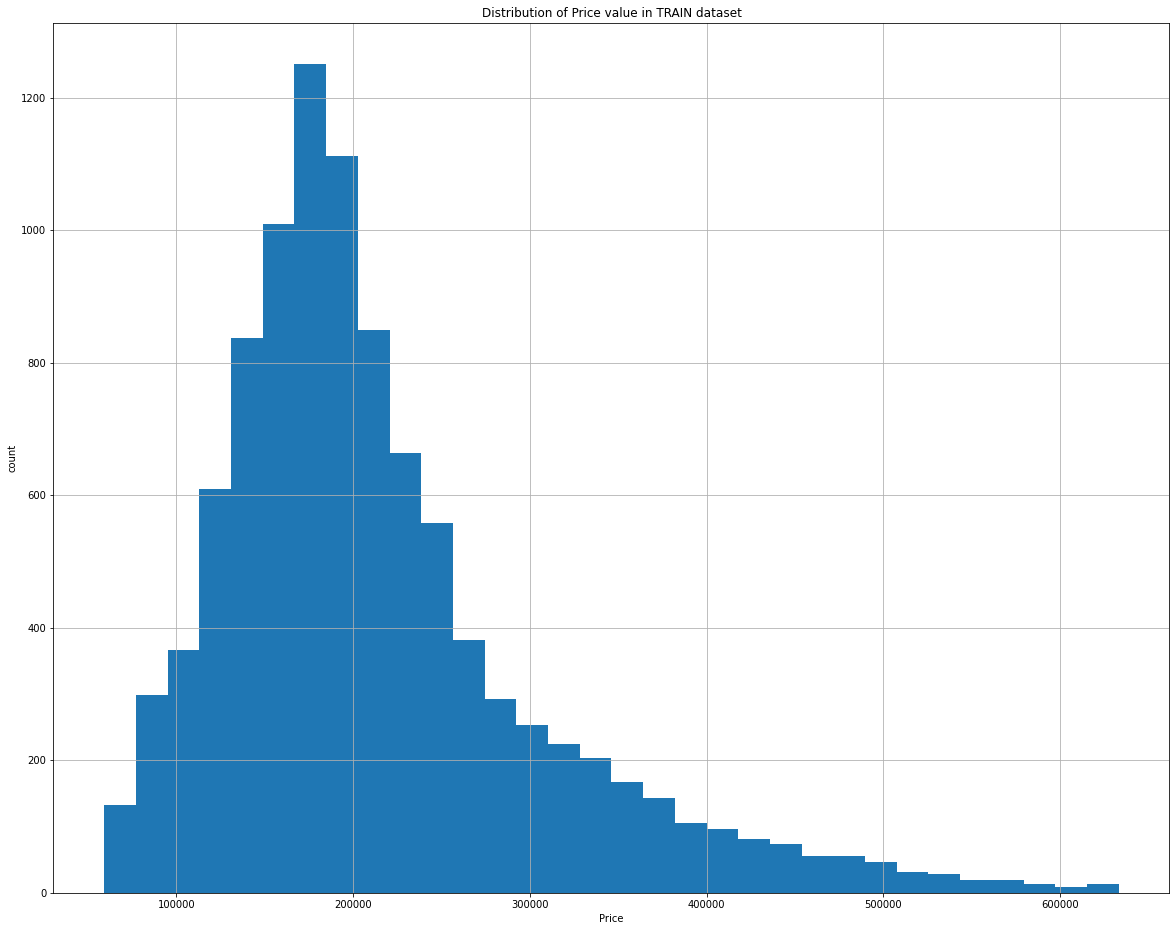

In [5]:
plot_features(train, 'Price', 32)

#### 1.1 Работа с выбросами

In [6]:
corrmat = train.corr()
corrmat

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Id,1.000000,0.012973,-0.005847,-0.010071,0.018449,0.019880,0.001348,-0.008376,0.005004,0.018097,-0.000772,-0.002033,-0.009358,-0.003879,0.001502,-0.008718,0.009880
DistrictId,0.012973,1.000000,0.071432,-0.026613,-0.019910,0.040358,-0.120373,-0.149051,0.013430,0.065294,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,0.265100
Rooms,-0.005847,0.071432,1.000000,0.662893,0.131336,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,0.550291
Square,-0.010071,-0.026613,0.662893,1.000000,0.196129,0.008320,0.114791,0.081505,-0.009032,-0.064479,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,0.520075
LifeSquare,0.018449,-0.019910,0.131336,0.196129,1.000000,-0.001195,0.024559,0.027442,-0.002210,-0.023629,-0.048363,-0.039283,0.012763,-0.026867,-0.024762,-0.007569,0.081292
KitchenSquare,0.019880,0.040358,0.005123,0.008320,-0.001195,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,0.028864
Floor,0.001348,-0.120373,-0.000665,0.114791,0.024559,-0.011397,1.000000,0.418986,0.000928,-0.016133,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,0.128715
HouseFloor,-0.008376,-0.149051,-0.029302,0.081505,0.027442,0.000780,0.418986,1.000000,-0.000864,-0.004362,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.088280
HouseYear,0.005004,0.013430,-0.010612,-0.009032,-0.002210,0.000958,0.000928,-0.000864,1.000000,0.001465,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.004305
Ecology_1,0.018097,0.065294,-0.032347,-0.064479,-0.023629,-0.005622,-0.016133,-0.004362,0.001465,1.000000,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,-0.058381


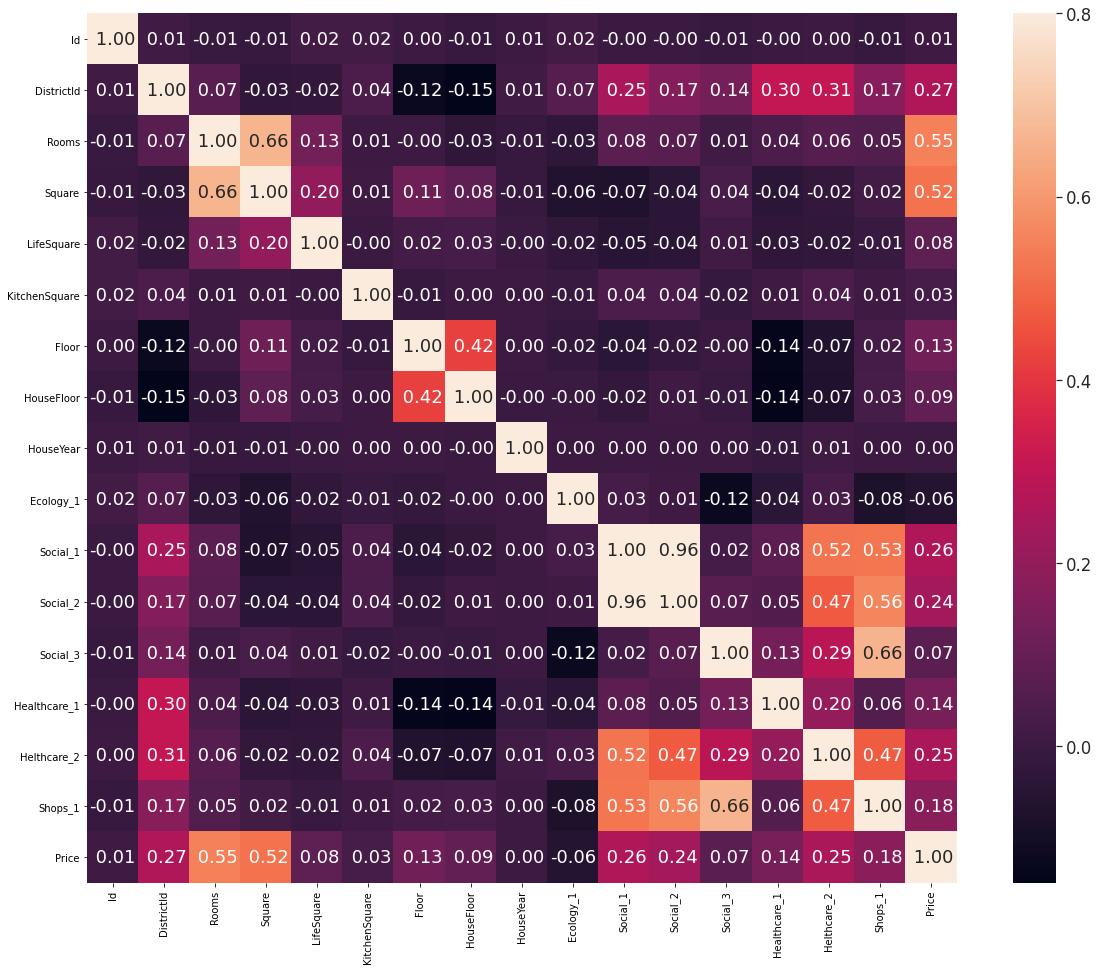

In [7]:
f, ax = plt.subplots(figsize=(20, 16))
sns.set(font_scale=1.5)
sns.heatmap(corrmat, vmax=.8, annot=True, fmt=' .2f', square=True);

In [8]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [9]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

#### Rooms

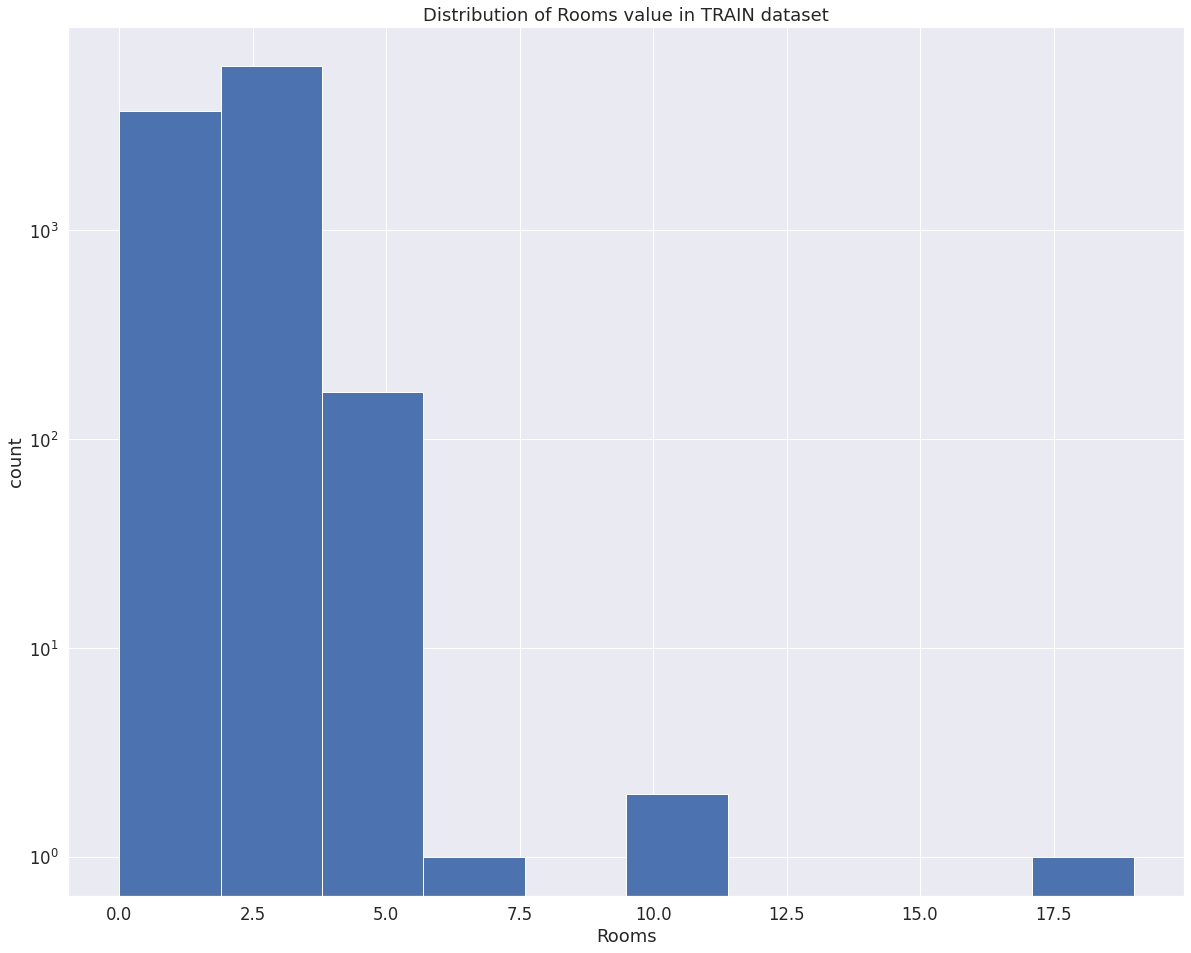

In [10]:
plot_features(train, 'Rooms', 10, True)

In [11]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [0]:
def roomsFeatures(X):
    """
        Выбросы:
            1. 0 - заменяю на медиану
            2. комнат больше 5 - заменяю на медиану
            3. больше 100 кв.м однокомнатная квартира - заменяю на медиану
    """
    median_rooms = X['Rooms'].median()
    X.loc[(X['Rooms'] == 0 ) | (X['Rooms'] > 5) , 'Rooms'] = median_rooms
    X.loc[((X['Rooms'] == 1) & (X['Square'] > 100) ), 'Rooms'] = median_rooms
    return X

#### LifeSquare

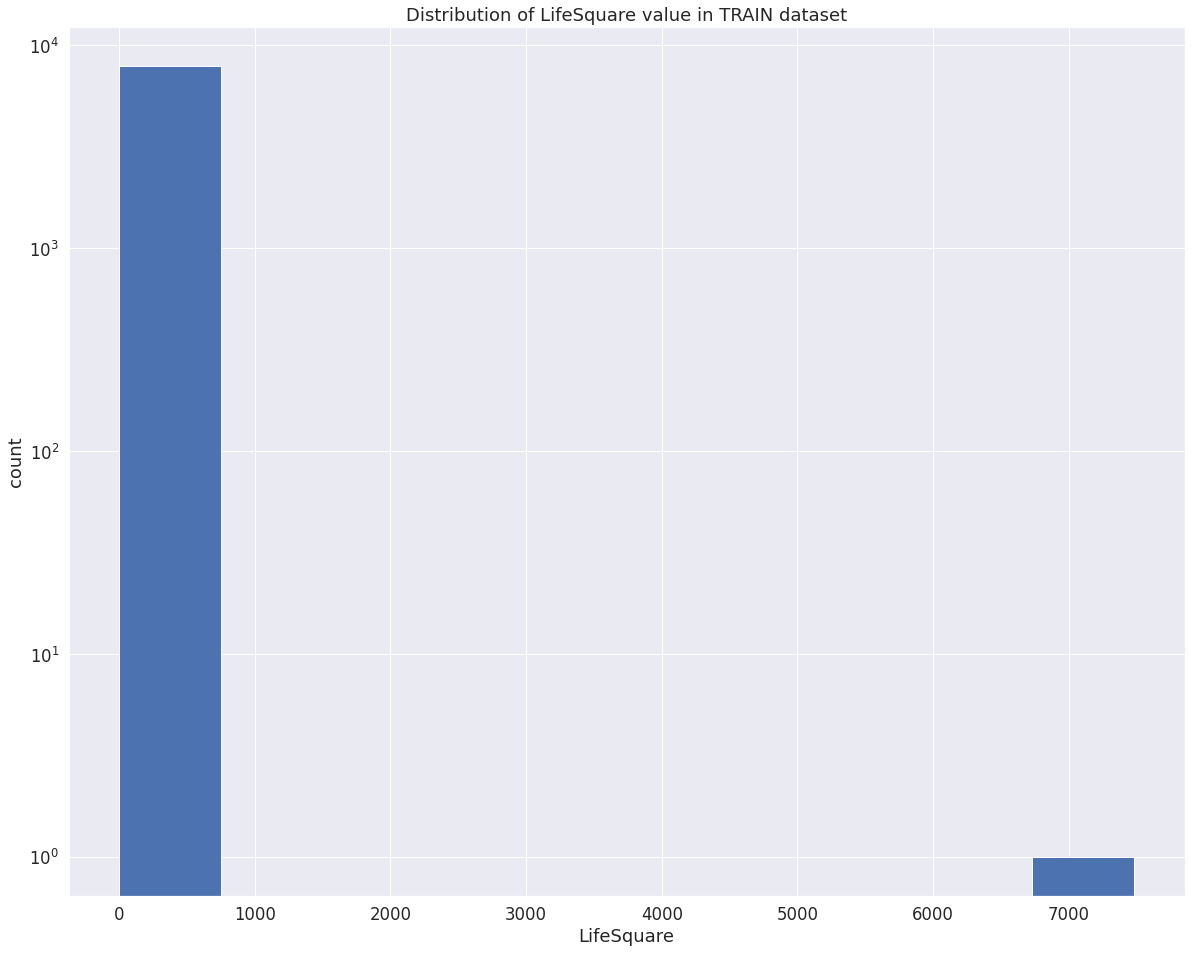

In [13]:
plot_features(train, 'LifeSquare', 10, True)

In [0]:
def lifeSquareFeatures(X):
    """
        Выбросы:
            1. Пустые значения и 0 - замена на медиану
            2. Жилая площадь должна быть не больше общей площади
    """
    median_lifeSquare = X['LifeSquare'].median()
    X.loc[X['LifeSquare'] > X['Square'], 'Square'] = X['LifeSquare']
    X['LifeSquare'] = X['LifeSquare'].fillna(median_lifeSquare)

    X.loc[X['LifeSquare'] < 1,'LifeSquare'] = X['LifeSquare'] * 100
    X.loc[X['LifeSquare'] < 10,'LifeSquare'] = X['LifeSquare'] * 10
    X.loc[X['LifeSquare'] == 0, 'LifeSquare'] = median_lifeSquare
    
    return X

#### Healthcare_1

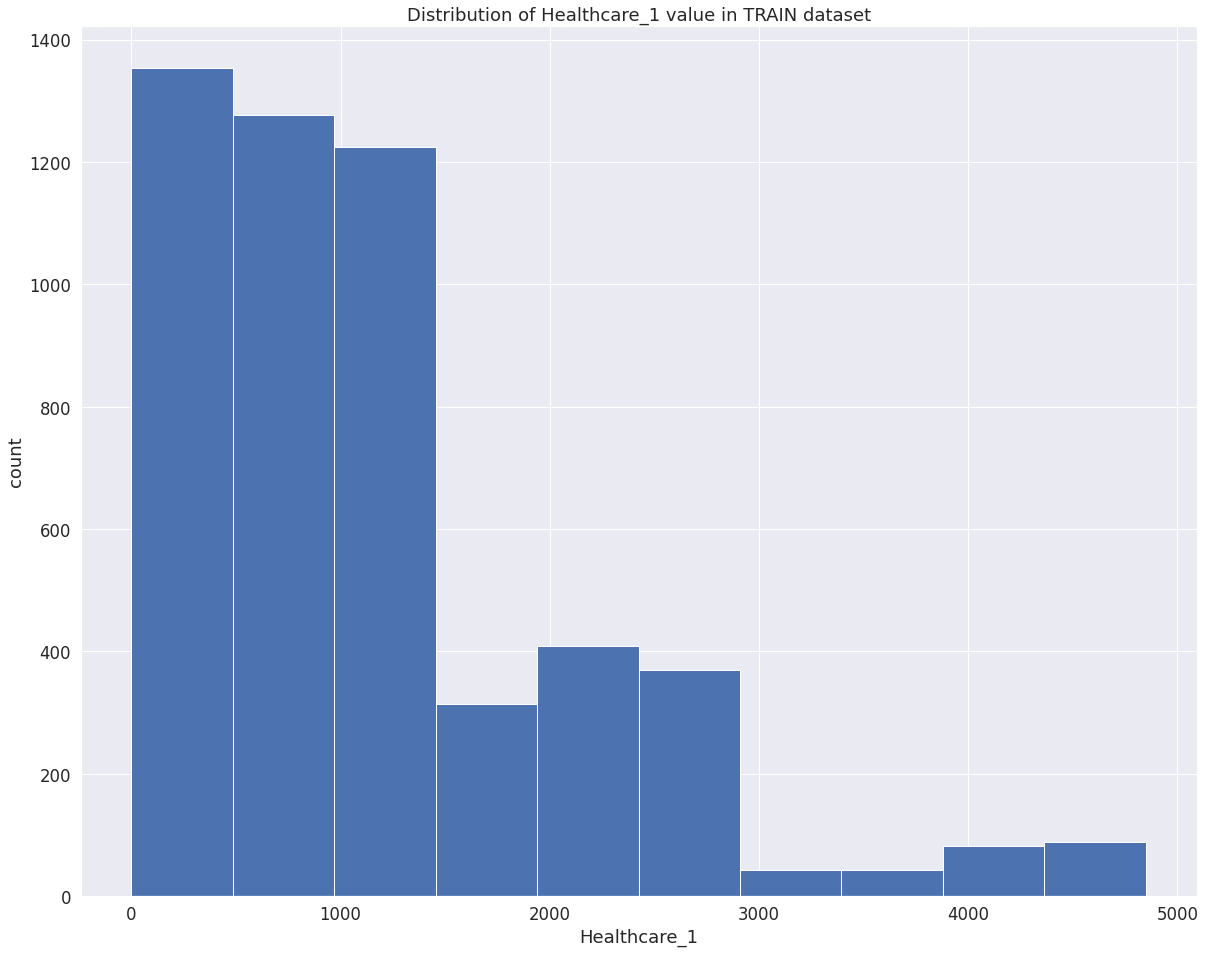

In [15]:
plot_features(train, 'Healthcare_1', 10)

In [0]:
def healthCare1Features(X):
    """
        Выбросы (пустые значения) заменяю на медиану
    """
    median_hc1 = X['Healthcare_1'].median()
    X['Healthcare_1'] = X['Healthcare_1'].fillna(median_hc1)

    return X

#### Floor, HouseFloor

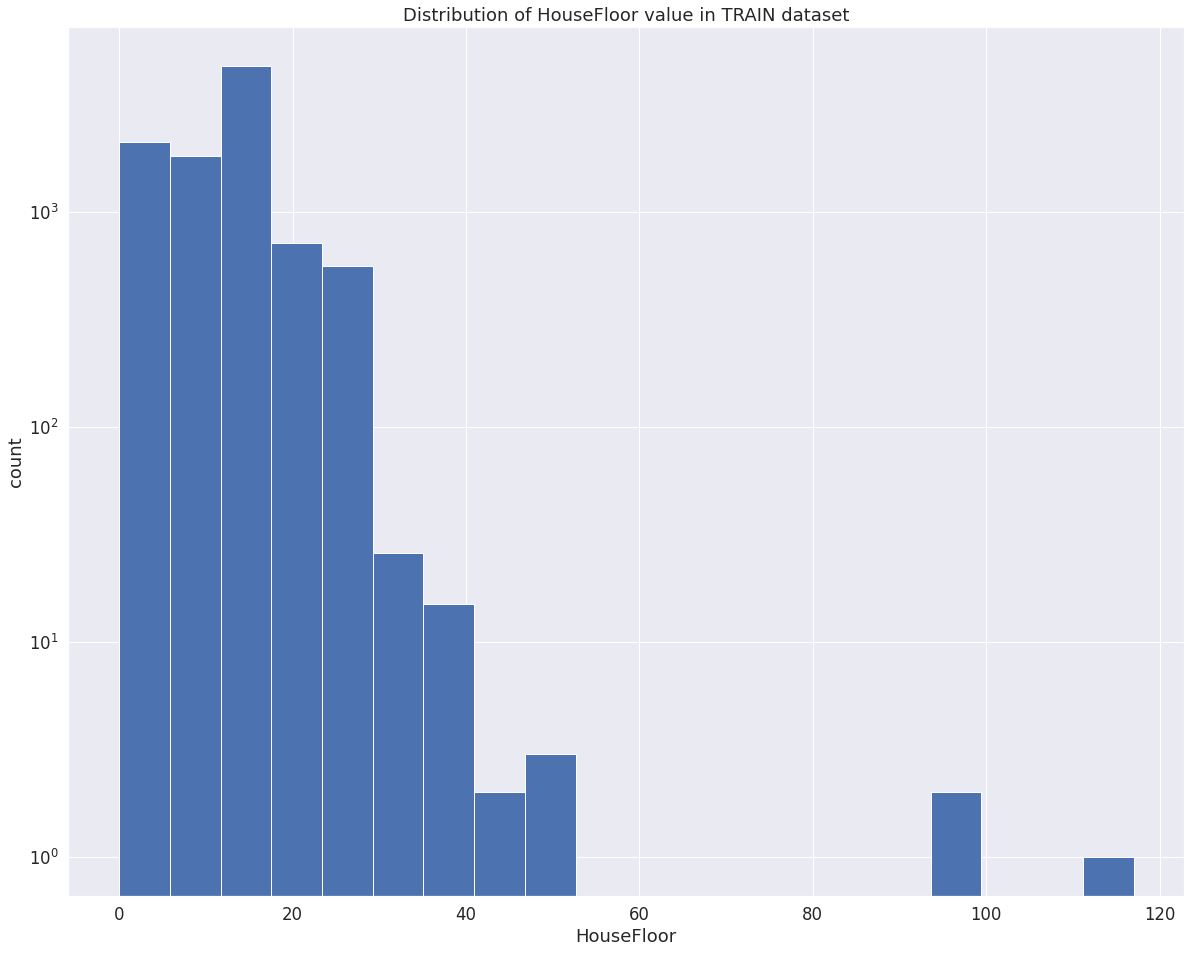

In [17]:
plot_features(train, 'HouseFloor', 20, True)

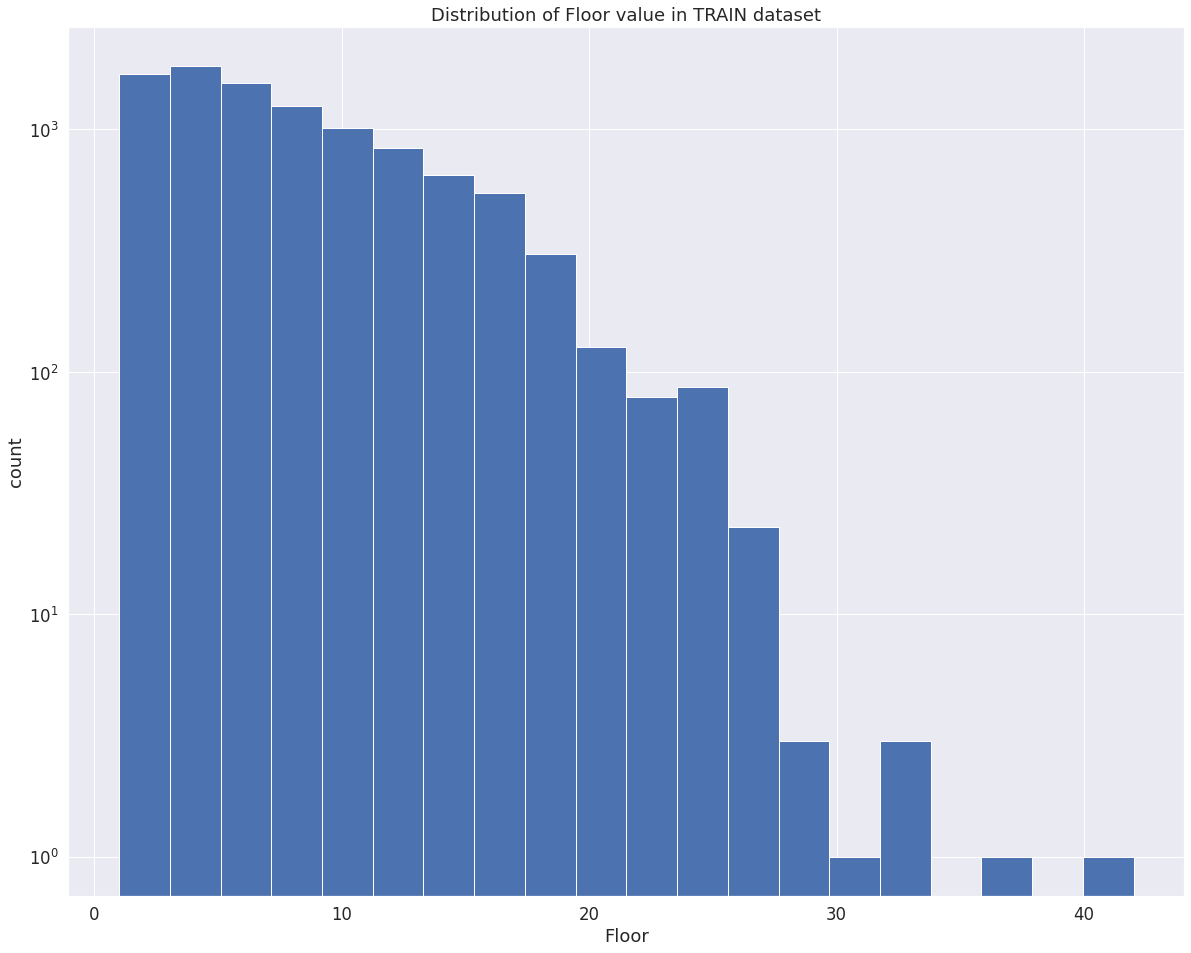

In [18]:
plot_features(train, 'Floor', 20, True)

In [0]:
def houseFloorFeatures(X):
    """
       Нулевые значения заменяю на медиану
    """
    median_houseFloor = X['HouseFloor']
    X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = median_houseFloor

    return X    

In [0]:
def floorFeatures(X):
    """
        Этаж больше, чем в доме - заменяю на количество этажей в доме
    """
    X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X['HouseFloor']
    
    return X

### 2. Очистка и подготовка данных

In [0]:
X = train
X_test = test
y = train['Price']
train.drop('Price', axis=1, inplace=True)

In [0]:
preds_final = pd.DataFrame()
preds_final['Id'] = test['Id'].copy()

In [0]:
def prepare_dataset(X):
    X = lifeSquareFeatures(X)
    X = healthCare1Features(X)
    X = roomsFeatures(X)
    X = houseFloorFeatures(X)
    X = floorFeatures(X)
    
    return X

In [0]:
X = prepare_dataset(X)
X_test = prepare_dataset(X_test)

In [0]:
# Удаляю шумовые признаки
to_del_list = ["Id", "Ecology_2", "Ecology_3", "Shops_2"]
X.drop(to_del_list, axis=1, inplace=True)
X_test.drop(to_del_list, axis=1, inplace=True)

### 3. Построение модели

In [0]:
# Разбиваю датасет
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [0]:
# parameters = [{
#     'max_features': [7,8,9],
#     'n_estimators': [600, 900, 1000, 1100]
# }]
# clf = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=100, max_features=7),
#     param_grid=parameters,
#     scoring='r2',
#     cv=4,
#     n_jobs=-1,
# )
# clf.fit(X_train, y_train)

# model = clf.best_estimator_

#### Выбираю самые подходящие параметры модел

In [0]:
model = RandomForestRegressor(n_estimators=1000, max_depth=16, random_state=100, max_features=7)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_pred_final = model.predict(X_test)

R2:	0.95
RMSE:	20824.214
MSE:	433647892.14


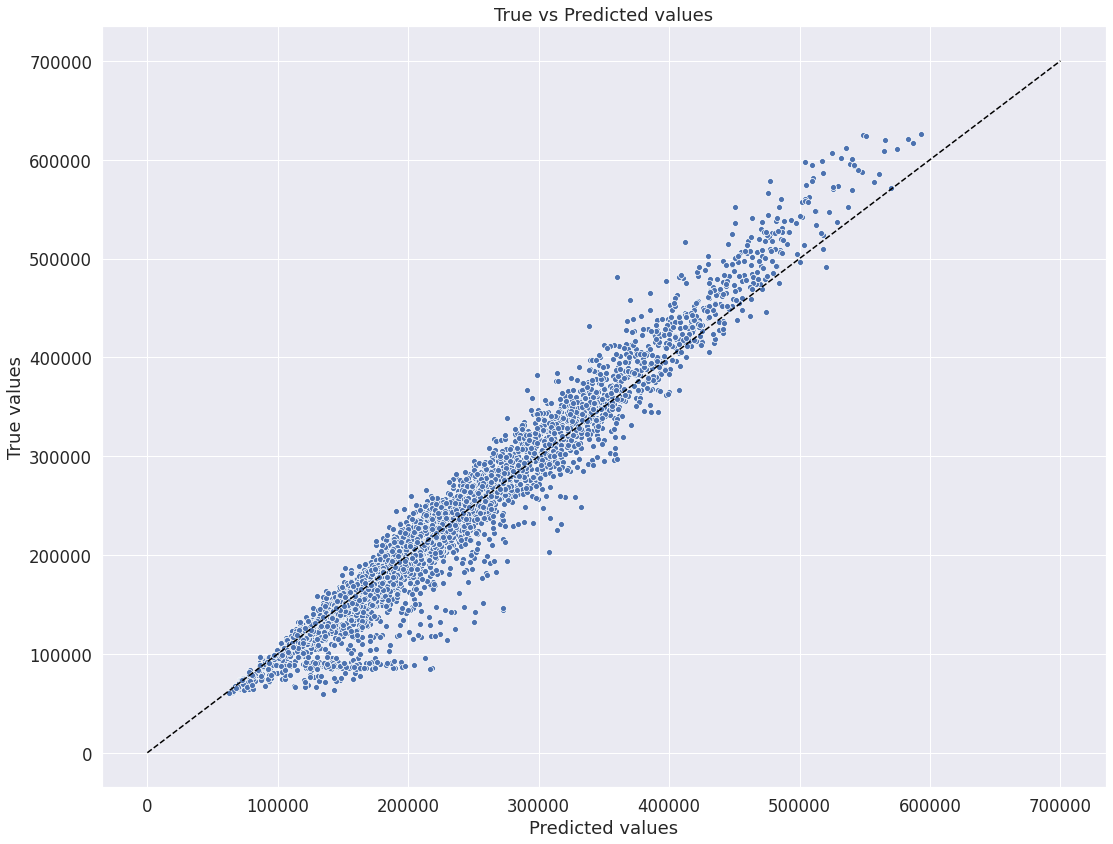

In [29]:
evaluate_preds(y_train, y_train_pred)

R2:	0.724
RMSE:	48782.933
MSE:	2379774565.769


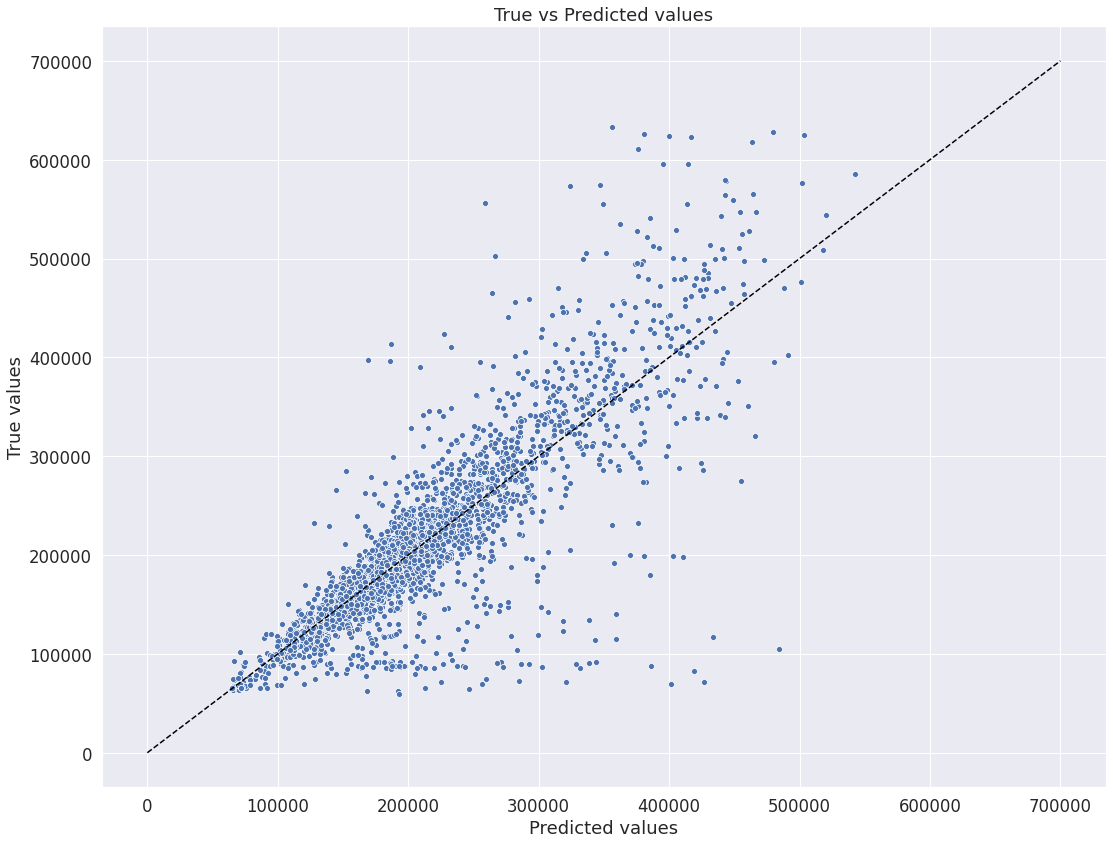

In [30]:
evaluate_preds(y_valid, y_valid_pred)

### Обучаю модель на полном train

In [0]:
model = RandomForestRegressor(n_estimators=1000, max_depth=16, random_state=100, max_features=7)

model.fit(X, y)
y_train_pred = model.predict(X)
y_pred_final = model.predict(X_test)

R2:	0.943
RMSE:	22158.342
MSE:	490992108.358


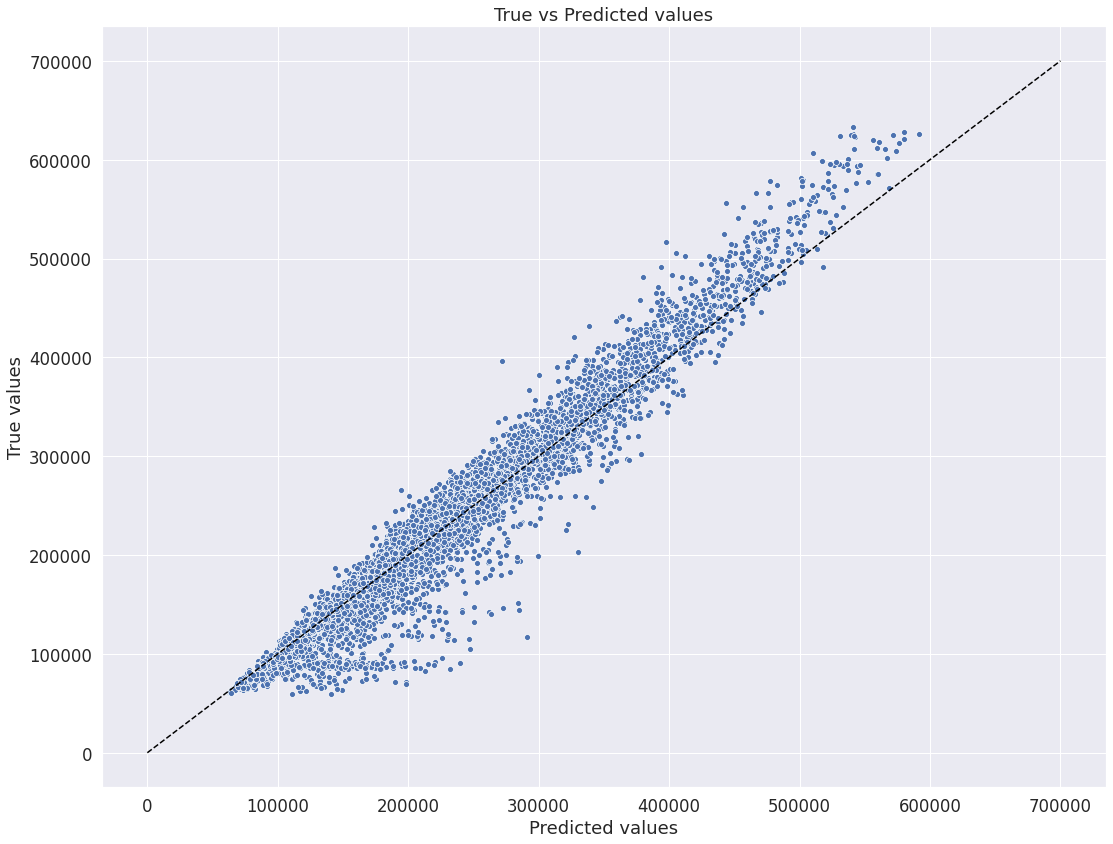

In [32]:
evaluate_preds(y, y_train_pred)

In [0]:
preds_final['Price'] = y_pred_final
preds_final.to_csv('Pavel_Tyukin_predictions.csv', index=False)

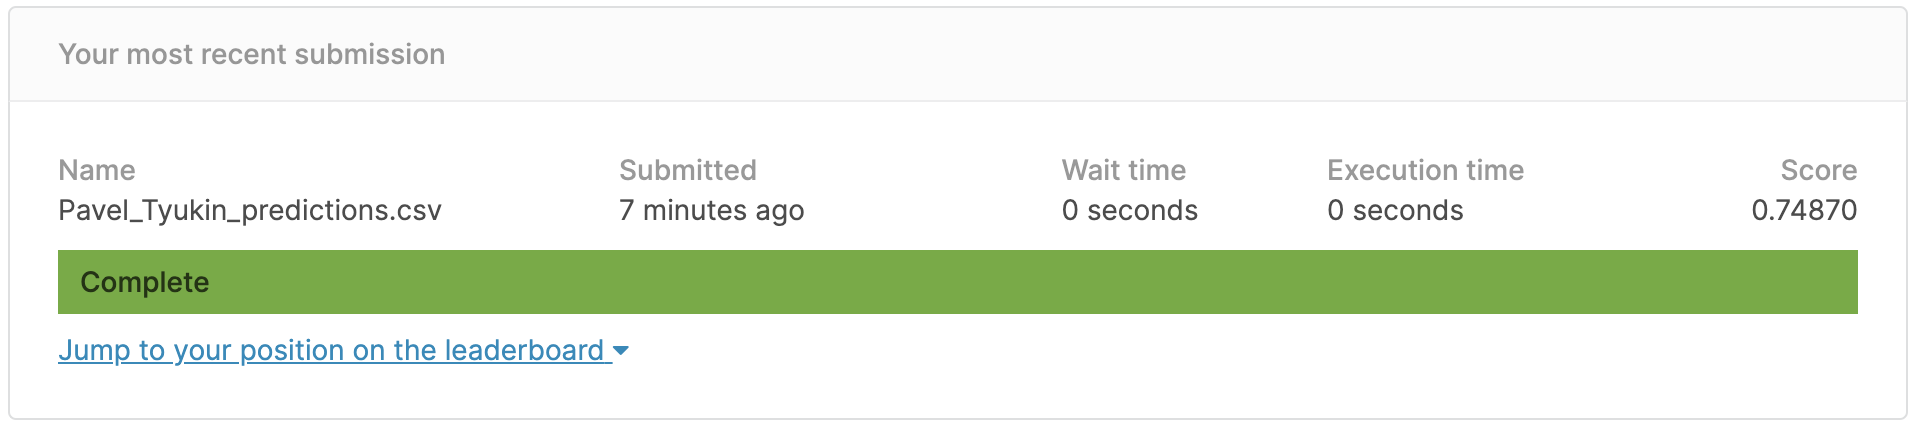

In [34]:
from IPython.display import Image

display(Image(filename='predict.png', width = 1000))